# End-to-End Credit Assignments in Vision

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision as tv
import torchvision.transforms as tvt

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from data import Modality
from models import MultiModalClassifier
from util import SequentialCreditAssignmentsHandler

---

In [2]:
model = MultiModalClassifier(modality=Modality.IMGS, n_classes=1000)
state_dict = torch.load('checkpoints/pretrained_imagenet-1k_head_for_microsoft-beit-large-patch16-224.state_dict', map_location='cpu')
model.head.load_state_dict(state_dict)
model.eval()

_square_img = tvt.Compose([tvt.Resize(size=(int(224/0.9), int(224/0.9)), interpolation=Image.Resampling.BICUBIC), tvt.CenterCrop(224)])
_img_to_inp = tvt.Compose([tvt.ToTensor(), tvt.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

credit_assignments = SequentialCreditAssignmentsHandler()
for routing in model.head.route:
    routing.return_dict = True
    credit_assignments.add_forward_hook(routing)

In [3]:
def _get_credit_assignments_for_vision_sample(img):

    img = _square_img(img)

    with torch.no_grad():
        credit_assignments.clear()
        scores = model(_img_to_inp(img)[None, :, :, :])

    prod = credit_assignments.end_to_end_prod()[0]
    pred_class = scores[0].argmax(-1).item()

    credit_to_hid_embs = prod[:, pred_class].view(-1, model.transformer_config['d_depth'])[1:]  #.abs()  # magnitudes
    credit_to_img_patches = credit_to_hid_embs.sum(dim=-1)

    return {
        'img': img,
        'pred_class': pred_class,
        'credit_to_hid_embs': credit_to_hid_embs,
        'credit_to_img_patches': credit_to_img_patches,
    }

(-0.5, 223.5, 223.5, -0.5)

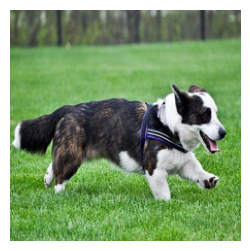

In [4]:
img = Image.open('assets/sample_image.jpg')
data = _get_credit_assignments_for_vision_sample(img)  # try a random image from ImageNet-1K

fig, axis = plt.subplots(figsize=(3, 3))
axis.imshow(data['img'])  # show resized image
axis.axis('off')

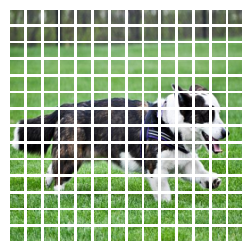

In [5]:
patches = [data['img'].crop((i, j, i + 16, j + 16)) for i in range(0, 224, 16) for j in range(0, 224, 16)]

fig, axes = plt.subplots(ncols=14, nrows=14, figsize=(3, 3))
for axis, patch in zip(axes.T.flatten(), patches):
    axis.imshow(patch)
    axis.axis('off')

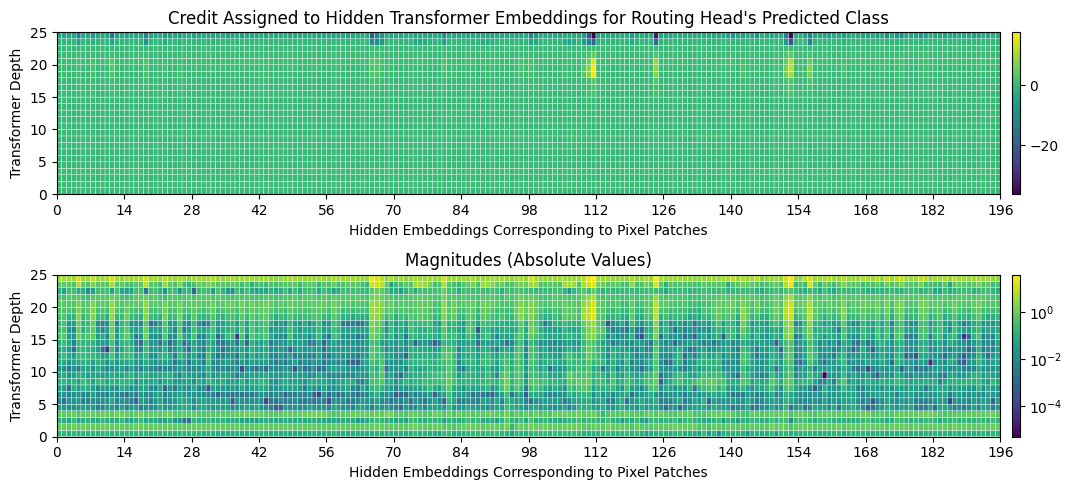

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 5))

axis = axes[0]
_colorable = axis.pcolor(data['credit_to_hid_embs'].T, edgecolor='w', lw=0.25)
axis.set_title("Credit Assigned to Hidden Transformer Embeddings for Routing Head's Predicted Class", fontsize=12)
axis.set(xlabel='Hidden Embeddings Corresponding to Pixel Patches', ylabel='Transformer Depth', xticks=range(0, 197, 14))
fig.colorbar(_colorable, ax=axis, pad=0.01)

axis = axes[1]
_colorable = axis.pcolor(data['credit_to_hid_embs'].T.abs(), edgecolor='w', lw=0.25, norm='log')
axis.set_title("Magnitudes (Absolute Values)", fontsize=12)
axis.set(xlabel='Hidden Embeddings Corresponding to Pixel Patches', ylabel='Transformer Depth', xticks=range(0, 197, 14))
fig.colorbar(_colorable, ax=axis, pad=0.01)


fig.tight_layout()

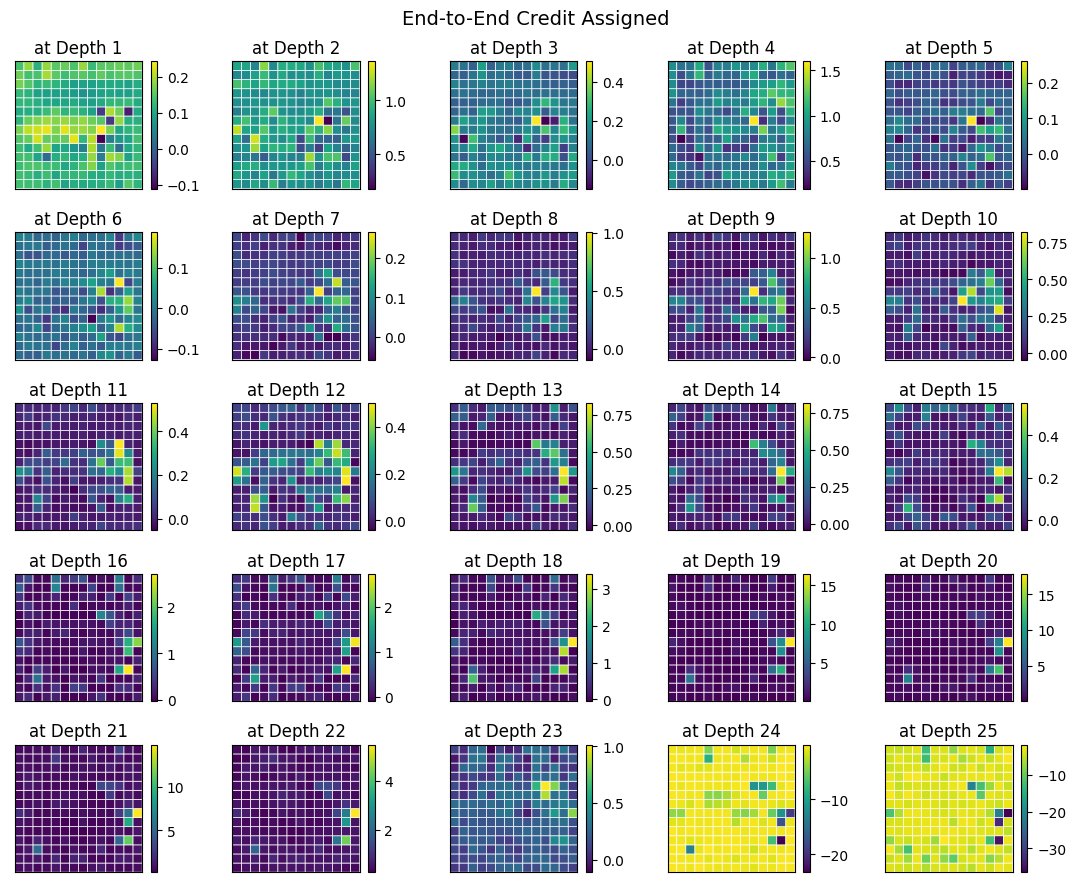

In [7]:
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(11, 9))
for i, (axis, heatmap) in enumerate(zip(axes.flatten(), data['credit_to_hid_embs'].T)):
    _colorable = axis.pcolor(reversed(heatmap.view(14, 14)), edgecolor='w', lw=0.5)
    fig.colorbar(_colorable, ax=axis)
    axis.set(title=f'at Depth {i + 1}', xticks=[], yticks=[])
    axis.set_aspect(1)
fig.suptitle('End-to-End Credit Assigned', fontsize=14)
fig.tight_layout()

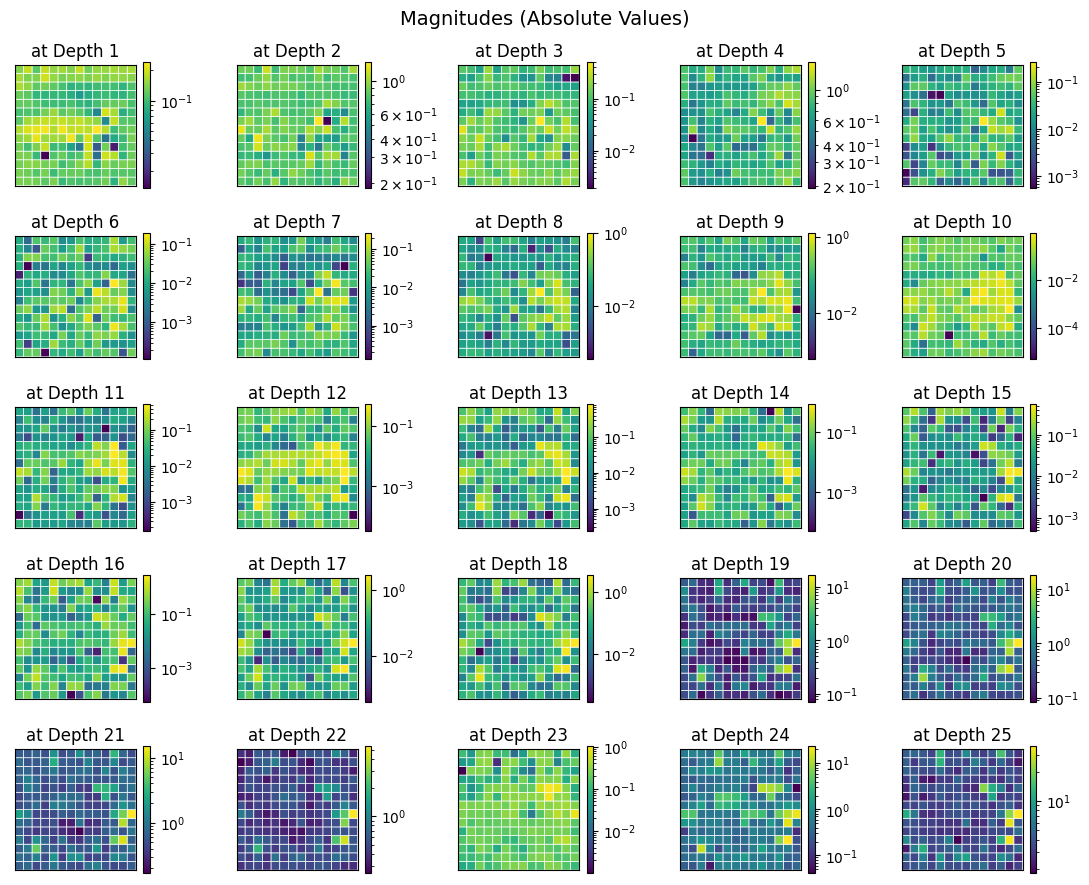

In [8]:
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(11, 9))
for i, (axis, heatmap) in enumerate(zip(axes.flatten(), data['credit_to_hid_embs'].T)):
    _colorable = axis.pcolor(reversed(heatmap.view(14, 14).abs()), edgecolor='w', lw=0.5, norm='log')
    fig.colorbar(_colorable, ax=axis)
    axis.set(title=f'at Depth {i + 1}', xticks=[], yticks=[])
    axis.set_aspect(1)
fig.suptitle('Magnitudes (Absolute Values)', fontsize=14)
fig.tight_layout()

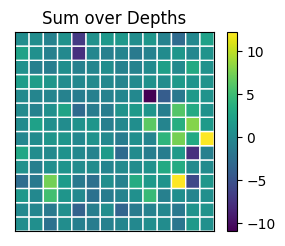

In [9]:
fig, axis = plt.subplots(figsize=(3, 2.5))
_colorable = axis.pcolor(reversed(data['credit_to_img_patches'].view(14, 14)), edgecolor='w', lw=1)
fig.colorbar(_colorable)
axis.set(title='Sum over Depths', xticks=[], yticks=[])
axis.set_aspect(1)
fig.tight_layout()

In [10]:
# Clear credit assignments and remove hooks.
credit_assignments.clear()
credit_assignments.remove_hooks()